<a href="https://colab.research.google.com/github/8kelena8/machine_learning/blob/main/Analyzing_Disordered_Audio_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Downloading dataset to notebook environment**

In [1]:
import kagglehub

path = kagglehub.dataset_download("mhantor/russian-voice-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.30G/1.30G [00:44<00:00, 31.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mhantor/russian-voice-dataset/versions/3


### **Moving the dataset for easier access**

In [5]:
!mv /root/.cache/kagglehub/datasets/mhantor/russian-voice-dataset/versions/3 /content/sample_data/

### **Installing necessary packaged and dependencies**

In [1]:
!pip install librosa scikit-learn matplotlib

### **Importing libraries**

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix


### **Load and process data using Root Mean Square (RSM)**

In [3]:
base_dir = '/content/sample_data/3'

normal_dir = os.path.join(base_dir, 'Normal Voices', 'Normal Voices')
disorder_dir = os.path.join(base_dir, 'Disorder Voices', 'Disorder Voices')

def extract_rms_feature(file_path):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    return rms

X, y = [], []

for file in os.listdir(normal_dir):
    if file.endswith('.wav'):
        filepath = os.path.join(normal_dir, file)
        rms = extract_rms_feature(filepath)
        X.append(rms)
        y.append("normal")

for file in os.listdir(disorder_dir):
    if file.endswith('.wav'):
        filepath = os.path.join(disorder_dir, file)
        rms = extract_rms_feature(filepath)
        X.append(rms)
        y.append("disorder")

lengths = [len(x) for x in X]
max_len = int(np.percentile(lengths, 90))
print(f"Dynamic max_len set to: {max_len}")

X_padded = []
for x in X:
    if len(x) > max_len:
        x = x[:max_len]
    else:
        x = np.pad(x, (0, max_len - len(x)), 'constant')
    X_padded.append(x)

X = np.array(X_padded)[..., np.newaxis]
print("Final input shape for CNN:", X.shape)


Dynamic max_len set to: 548
Final input shape for CNN: (4000, 548, 1)


### **Encode labels and split data for training**

In [4]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


### **Building the convolutional neural network (CNN)**

In [5]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 546, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 273, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 271, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 135, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8640)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       553,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 559,490 (2.13 MB)

 Trainable params: 559,490 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### **Training the model**

In [6]:
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8847 - loss: 0.2845 - val_accuracy: 0.9812 - val_loss: 0.0649
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9792 - loss: 0.0701 - val_accuracy: 0.9875 - val_loss: 0.0436
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9869 - loss: 0.0473 - val_accuracy: 0.9900 - val_loss: 0.0348
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9855 - loss: 0.0398 - val_accuracy: 0.9775 - val_loss: 0.0694
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9848 - loss: 0.0530 - val_accuracy: 0.9937 - val_loss: 0.0321
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9930 - loss: 0.0301 - val_accuracy: 0.9912 - val_loss: 0.0413
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9891 - loss: 0.0356 - val_accuracy: 0.9925 - val_loss: 0.0346
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9824 - loss: 0.0503 - val_accu

### **Evaluating the model**

In [7]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9913 - loss: 0.0474
Test Accuracy: 0.99


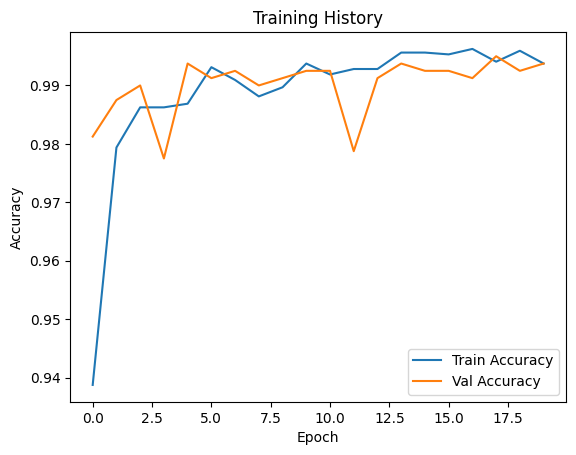

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()


Evaluation of the model: accuracy, recall, F1 score and Confussion matrix

In [9]:
y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       378
           1       0.99      1.00      0.99       422

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Confusion Matrix:
[[373   5]
 [  0 422]]


In [11]:
!pip install gradio librosa --quiet

### **Building Web App with Gradio**

In [ ]:
import gradio as gr

def extract_rms(file):
    expected_length = 548
    y, sr = librosa.load(file, sr=None)
    rms = librosa.feature.rms(y=y)

    if rms.shape[1] < expected_length:
        rms = np.pad(rms, ((0, 0), (0, expected_length - rms.shape[1])), mode='constant')
    else:
        rms = rms[:, :expected_length]

    rms_input = rms.T.reshape(1, expected_length, 1).astype(np.float32)

    prediction = model.predict(rms_input)
    predicted_label = np.argmax(prediction)
    confidence = prediction[0][predicted_label]

    class_labels = ["Disorder", "Normal"]
    return f"✅ Predicted: **{class_labels[predicted_label]}**\nConfidence: {confidence:.2%}"

gr.Interface(
    fn=extract_rms,
    inputs=gr.Audio(type="filepath", label="Upload .wav File"),
    outputs=gr.Textbox(label="Prediction"),
    title="🎧 Audio Classification via CNN",
    description="Upload a .wav file. The system will extract RMS features and predict the class."
).launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7c5842cba8f4ba155e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
